# EDA / Testing

In this workbook we'll do our EDA and testing queries for further modeling.

I'd also like to get the function for going from mbid to song/album/artist going.

Process:
1. Setup notebook(Authenticate, import necessary imports).
2. Send query to BigQuery for data of top 25 songs from the past year.

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery

In [ ]:
project_id = 'listenbrainzrecommender'

In [ ]:
# Authenticate google cloud platform
# from google.colab import auth
# auth.authenticate_user()
# print('Authenticated')

Authenticated


In [ ]:
# Test loading in full dataframe on laptop
# %%bigquery --project listenbrainzrecommender big_df
# SELECT
#   *
# FROM
#   `listenbrainz.listenbrainz.listen`

In [ ]:
# big_df.head()

In [ ]:
# def Get_Name(song_name):
#   %%bigquery --project listenbrainzrecommender test_df
#   SELECT
#     recording_mbid
#   FROM
#     `listenbrainz.listenbrainz.listen`
#   WHERE
#     track_name == song_name

In [ ]:
client = bigquery.Client(project=project_id)

In [ ]:
top25songs = client.query('''
SELECT
  recording_mbid,
  COUNT(user_name) AS song_plays
FROM
  `listenbrainz.listenbrainz.listen`
WHERE
  LENGTH(recording_mbid) > 0
GROUP BY
  recording_mbid
ORDER BY
  song_plays DESC
LIMIT
  25
''').to_dataframe()

In [ ]:
top25songs

,recording_mbid,song_plays
0,0d84f538-6dfc-4d7f-9c7a-11098dad829d,113342
1,94e11995-ccb0-4b18-afda-b742ad9c55ee,49199
2,0ebe2d92-a11d-4b2b-9922-806383074ed7,14859
3,0790ba6c-e0b1-4891-b82f-b4db9a5a927f,14174
4,04a4ac3e-5439-4214-8094-b63f756613ea,12988
5,534e0d59-58a8-4594-aaab-847398098ff7,12865
6,e05035a3-14ac-4f88-a160-0a144530004e,12541
7,67b5513d-0119-439f-9352-521f17d205e7,12332
8,f1a6a40f-78f5-4918-968d-f64363bae94c,12175
9,5660558a-bfa7-416f-99d9-a34ca0a34515,11989


In [ ]:
top2500songs = client.query('''
SELECT
  recording_mbid,
  COUNT(user_name) AS song_plays
FROM
  `listenbrainz.listenbrainz.listen`
WHERE
  LENGTH(recording_mbid) > 0
GROUP BY
  recording_mbid
ORDER BY
  song_plays DESC
LIMIT
  2500
''').to_dataframe()

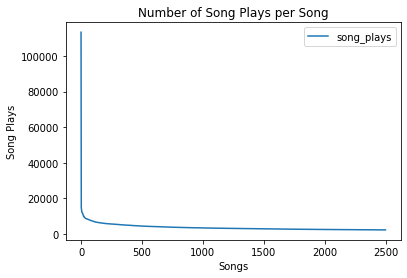

In [ ]:
ax = top2500songs.plot()

plt.xlabel("Songs")
plt.ylabel("Song Plays")
plt.title("Number of Song Plays per Song");

# Analysis

We can see that this is a 'long tail' problem and so is a good candidate for a recommender system.

We have a baseline ready, where the system will only recommend the top 25 songs regardless of input.

The next step is to create a basic recommender.

I'll also create a song class. This class will have functionality to store a song's name/record/mbid's and can be used to get the song's other attributes.

In [ ]:
# prototype song class
class Song:
  def __init__(self, artist_name, song_name):
    self.artist_name = artist_name
    self.song_name = song_name

We'll test getting the song info next, to make song objects.
The songs each have a unique mbid, so we can just group by recording_mbid first, and the other groupings will only have 1 group per song.

In [ ]:
# test getting other song info
top25songinfo = client.query('''
SELECT
  recording_mbid,
  COUNT(user_name) AS song_plays,
  artist_name AS artist,
  release_name AS album,
  track_name AS title

FROM
  `listenbrainz.listenbrainz.listen`
WHERE
  LENGTH(recording_mbid) > 0
GROUP BY
  recording_mbid, artist_name, release_name, track_name
ORDER BY
  song_plays DESC
LIMIT
  25
''').to_dataframe()

In [ ]:
top25songinfo.head()

,recording_mbid,song_plays,artist,album,title
0,0d84f538-6dfc-4d7f-9c7a-11098dad829d,113335,近藤浩治,,Inside the Deku Tree
1,94e11995-ccb0-4b18-afda-b742ad9c55ee,49195,Michael Z. Land,,Docks Background Ambience
2,0790ba6c-e0b1-4891-b82f-b4db9a5a927f,11069,Radiohead,,Karma Police
3,0ebe2d92-a11d-4b2b-9922-806383074ed7,10692,Nirvana,,Smells Like Teen Spirit
4,04a4ac3e-5439-4214-8094-b63f756613ea,9787,Massive Attack,,Teardrop


In [ ]:
# test getting other song info
# Also test if data changes if mbid missing makes song list inaccurate
top25songinfo_nombid = client.query('''
SELECT
  COUNT(user_name) AS song_plays,
  artist_name AS artist,
  track_name AS title

FROM
  `listenbrainz.listenbrainz.listen`
GROUP BY
  artist_name, track_name
ORDER BY
  song_plays DESC
LIMIT
  25
''').to_dataframe()

In [ ]:
top25songinfo_nombid.head()

,song_plays,artist,title
0,113348,近藤浩治,Inside the Deku Tree
1,49199,Michael Z. Land,Docks Background Ambience
2,15159,Nirvana,Smells Like Teen Spirit
3,14378,Radiohead,Karma Police
4,13346,Massive Attack,Teardrop


In [ ]:
top25songinfo.head()

,recording_mbid,song_plays,artist,album,title
0,0d84f538-6dfc-4d7f-9c7a-11098dad829d,113335,近藤浩治,,Inside the Deku Tree
1,94e11995-ccb0-4b18-afda-b742ad9c55ee,49195,Michael Z. Land,,Docks Background Ambience
2,0790ba6c-e0b1-4891-b82f-b4db9a5a927f,11069,Radiohead,,Karma Police
3,0ebe2d92-a11d-4b2b-9922-806383074ed7,10692,Nirvana,,Smells Like Teen Spirit
4,04a4ac3e-5439-4214-8094-b63f756613ea,9787,Massive Attack,,Teardrop


In [ ]:
# Create song objects for top 25 songs
listOfSongs= [(Song(row.artist,row.title)) for index, row in top25songinfo_nombid.iterrows() ]  

In [ ]:
# listOfSongs
listOfSongs[0].song_name

'Inside the Deku Tree'

Nice! We have our custom test class working to create song objects. We can use this now to implement functions for the songs, like getting the listeners per song or lookup on spotify. But that will be later on.

For now we'll remake the test class and use it to get lists of people who listened to the top 25 songs to create a sparse matrix.

In [ ]:
# v2 song class
class Song:
  def __init__(self, artist_name, song_name):
    self.artist_name = artist_name
    self.song_name = song_name
  
  def get_listener_list(self):
    '''
    Gets the listeners for a given song.
    Does not take into account the amount an account has listened to a song.
    Returns a dataframe.
    '''
    self.listeners = client.query('''
      SELECT
        user_name
      FROM
        `listenbrainz.listenbrainz.listen`
      WHERE
        artist_name = \''''
      + self.artist_name + '''\'
        AND
        track_name = \''''
      + self.song_name + '''\'
      GROUP BY
        user_name
      ''').to_dataframe()

    return self.listeners

In [ ]:
listeners = listOfSongs[0].get_listeners()
listeners.head()

,user_name
0,BakeSulfur
1,aLeX90
2,August Janse
3,lb_test_1
4,NichoBI


In [ ]:
len(listeners)

25

Nice! We're able to get the listeners for any song object now.

Next is to work on creating the sparse matrix of listeners vs songs

I'll make the sparce matrix in the next notebook for the FSM.